In [1]:
from itertools import product

import numpy as np
import pandas as pd
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import harmonic_mean
from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm9_metrics import cai, pathway_coverage, max_positive_edge_density, max_synergetic_edge_density

In [2]:
from doe_modules.preferences import harmonic_mean

def pathway_positivity(arr):
    n_p = np.abs(arr)[:9].sum()
    return (arr[:9] == 1).sum() / n_p if n_p != 0 else 0


def positive_pathway_coverage(arr):
    return (arr[:9] == 1).sum() / 9


def pai(arr) -> float:
    return harmonic_mean(
        positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        pathway_positivity(arr),
        pathway_coverage(arr),
    )

def met1100(arr) -> float:
    return harmonic_mean(
        positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        # pathway_positivity(arr),
        # pathway_coverage(arr),
    )

def met0110(arr) -> float:
    return harmonic_mean(
        # positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        pathway_positivity(arr),
        # pathway_coverage(arr),
    )

def met0101(arr) -> float:
    return harmonic_mean(
        # positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        # pathway_positivity(arr),
        pathway_coverage(arr),
    )

def met1110(arr) -> float:
    return harmonic_mean(
        positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        pathway_positivity(arr),
        # pathway_coverage(arr),
    )

def met1101(arr) -> float:
    return harmonic_mean(
        positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        # pathway_positivity(arr),
        pathway_coverage(arr),
    )

def met0111(arr) -> float:
    return harmonic_mean(
        # positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        pathway_positivity(arr),
        pathway_coverage(arr),
    )

In [5]:
edges = np.load(f"{outputdir}/esm_test9_edges.npy")

df = pd.read_feather(
    f"{outputdir}/esm_test9.feather"
).assign(
    positive_pathway_coverage=pd.DataFrame({
        "positive_pathway_coverage": map(positive_pathway_coverage, edges),
    })
).assign(
    max_positive_edge_density_neg=pd.DataFrame({
        "max_positive_edge_density": map(lambda x: 1 - max_positive_edge_density(x), edges),
    })
)

df = df.assign(
    arithmetic=df.iloc[:, 8:10].mean(axis=1)
)

df = df.assign(
    better_with_pb=df.pb > df.cloo
)

In [6]:
df

,cloo,pb,v,,edge_coverage,pathway_sparsity,max_positive_edge_density,cai,positive_pathway_coverage,max_positive_edge_density_neg,arithmetic,better_with_pb
0,0.000000,0.121951,0,neither,0.777778,0.777778,0.318182,0.336000,0.222222,0.681818,0.452020,True
1,0.307692,0.415584,0,neither,0.722222,0.777778,0.086957,0.172566,0.555556,0.913043,0.734300,True
2,0.228571,0.366197,0,neither,0.666667,0.555556,0.416667,0.487805,0.444444,0.583333,0.513889,True
3,0.217391,0.000000,0,neither,0.638889,0.222222,0.000000,0.000000,0.000000,1.000000,0.500000,False
4,0.210526,0.357143,0,neither,0.611111,0.666667,0.454545,0.438830,0.333333,0.545455,0.439394,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.557377,0,neither,0.666667,0.444444,0.000000,0.000000,0.222222,1.000000,0.611111,True
9996,0.800000,0.000000,1,C+LOO,0.777778,0.555556,0.535714,0.555311,0.111111,0.464286,0.287698,False
9997,0.571429,0.000000,0,neither,0.527778,0.888889,0.642857,0.240958,0.444444,0.357143,0.400794,False
9998,0.000000,0.000000,0,neither,0.638889,0.888889,0.000000,0.000000,0.111111,1.000000,0.555556,False


In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    confusion_matrix(y_te, lr.predict(x_te.values.reshape(-1, 1))), 
    square=True, annot=True, fmt="", cmap="Blues",
    cbar_kws={"label": "sample counts", "shrink": .8}
)

ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"])
ax.set(xlabel="predicted label", ylabel="true label", title="Test dataset");

# if conf.savefig:
#     fig.savefig(f"{conf.out}/confusion_matrix{conf.suffix}", **kwarg_savefig)

In [9]:
def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.cloo < data.pb, data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.loc[:, ""] == "PB", data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

In [10]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

In [11]:
specificity_score(df.cloo < df.pb, df.cai <= .5)

0.11961384506710619

In [12]:
confusion_matrix(df.cloo < df.pb, df.cai <= .5)

array([[ 508, 3739],
       [ 203, 5550]])

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score

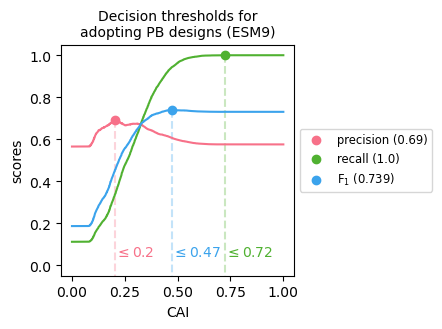

In [14]:
import warnings
warnings.simplefilter('ignore')

fig, ax = plt.subplots(figsize=(3, 3))

metrics = {
    # "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    # "specificity": specificity_score,
    "F$_1$": f1_score,
    # "AUROC": roc_auc_score,
    # "AP": average_precision_score,
}

argmax_recorder = {}

cmap = sns.color_palette("husl", len(metrics))

for  i, (k, metric) in enumerate(metrics.items()):
    x, y = cai_performance_plot(df, metric)
    ax.plot(x, y, color=cmap[i])
    idx = np.argmax(y)
    argmax_max = (x[idx], y[idx])
    ax.scatter(
        *argmax_max, 
        label=f"{k} ({argmax_max[1].round(3)})",
        color=cmap[i]
    )
    ax.vlines(*argmax_max, -0.05, color=cmap[i], linestyle="--", zorder=-100, alpha=.3)
    ax.text(argmax_max[0], .03, "$\leq$" + f"{argmax_max[0].round(2)}", color=cmap[i], ha="left", va="bottom")
    
    argmax_recorder = {**argmax_recorder, k: argmax_max[0]}

ax.set_xlim(-.05, 1.05)
ax.set_ylim(-.05, 1.05)

ax.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="small")

ax.set_title("Decision thresholds for\nadopting PB designs (ESM9)", size="medium")
ax.set(xlabel="CAI", ylabel="scores")

fig.savefig(f"{outputdir}/decision_thresh_test9", **kwarg_savefig)

In [16]:
def div22(arr):
    n = (-1 + np.sqrt(1 + 8 * arr.size)) / 2
    weight = np.array([1 / n, 1 - (1 / n)])
    val = np.array([
        positive_pathway_coverage(arr),
        (1 - max_positive_edge_density(arr)),
        # pathway_positivity(arr),
        # pathway_coverage(arr)
    ])
    return (weight * val).sum() / weight.sum()

In [17]:
df = df.assign(
    div22=pd.DataFrame({
        "": map(div22, edges),
    })
)

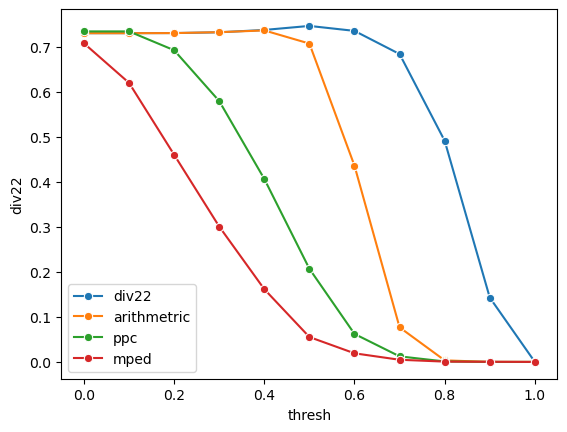

In [18]:
from sklearn.metrics import f1_score

fig, ax = plt.subplots()

thresh = np.linspace(0, 1, 11)
hoge = pd.DataFrame({
    "thresh": thresh,
    "div22": np.vectorize(lambda t: f1_score(df.better_with_pb, df.div22 > t))(thresh),
    "arithmetric": np.vectorize(lambda t: f1_score(df.better_with_pb, df.arithmetic > t))(thresh),
    "ppc": np.vectorize(lambda t: f1_score(df.better_with_pb, df.positive_pathway_coverage > t))(thresh),
    "mped": np.vectorize(lambda t: f1_score(df.better_with_pb, df.max_positive_edge_density > t))(thresh),
})

for key in ["div22", "arithmetric", "ppc", "mped"]:
    sns.lineplot(
        data=hoge, x="thresh", y=key, label=key, marker="o"
    )

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score, precision_recall_curve

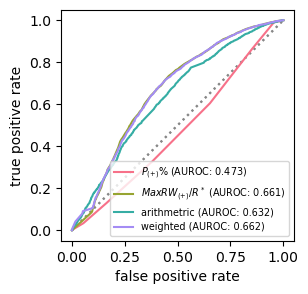

In [20]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density_neg, 
    df.arithmetic, 
    df.div22, 
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", 
    "arithmetric", 
    "weighted",
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small")
ax.set(xlabel="false positive rate", ylabel="true positive rate")

fig.savefig(f"{outputdir}/test9_roc", **kwarg_savefig)

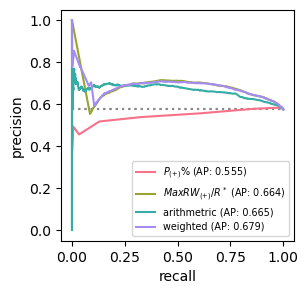

In [23]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density_neg, 
    df.arithmetic, 
    df.div22, 
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", 
    "arithmetric", 
    "weighted",
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax.plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small")
ax.set(xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test9_pr", **kwarg_savefig)

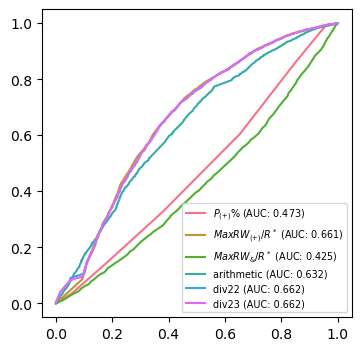

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density_neg, 
    df.max_synergetic_edge_density,
    # df.pathway_positivity,
    # df.pathway_coverage, 
    # df.edge_sparsity,
    df.arithmetic, 
    # df.geometric, 
    # df.met1100, df.met0110, df.met0101, df.met1110, df.met1101, df.met0111,
    # df.arith0101, 
    # df.max0101, df.min0101,
    # df.div0101, df.e0101,
    # df.div2, df.div3, 
    df.div22, df.div23,
    # # df.div4,
    # df.pai
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", 
    "$MaxRW_{&}/R^*$", 
    # "$P_{(+)}/P$", 
    # "$P\%$", 
    # "$1-R\%$",
    "arithmetic", 
    # "geometric", 
    # "met1100", "met0110", "met0101", "met1110", "met1101", "met0111",
    # "arith0101", 
    # "max0101", "min0101",
    # "div0101", "e0101",
    # "div2", "div3", 
    "div22", "div23",
    # "div4",
    # "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [24]:
from sklearn.metrics import precision_recall_curve

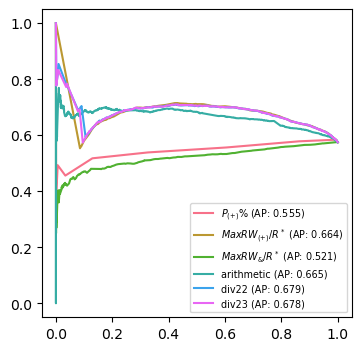

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density_neg, 
    df.max_synergetic_edge_density,
    # df.pathway_positivity,
    # df.pathway_coverage, 
    # df.edge_sparsity,
    df.arithmetic, 
    # df.geometric, 
    # df.met1100, df.met0110, df.met0101, df.met1110, df.met1101, df.met0111,
    # df.arith0101, 
    # df.max0101, df.min0101,
    # df.div0101, df.e0101,
    # df.div2, df.div3, 
    df.div22, df.div23,
    # # df.div4,
    # df.pai
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", 
    "$MaxRW_{&}/R^*$", 
    # "$P_{(+)}/P$", 
    # "$P\%$", 
    # "$1-R\%$",
    "arithmetic", 
    # "geometric", 
    # "met1100", "met0110", "met0101", "met1110", "met1101", "met0111",
    # "arith0101", 
    # "max0101", "min0101",
    # "div0101", "e0101",
    # "div2", "div3", 
    "div22", "div23",
    # "div4",
    # "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

AttributeError: 'DataFrame' object has no attribute 'div2'

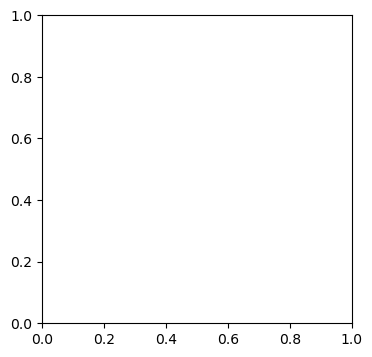

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    # df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    # df.pathway_coverage, 
    # df.edge_sparsity,
    # df.arithmetic, df.geometric, 
    # df.met1100, df.met0110, df.met0101, df.met1110, df.met1101, df.met0111,
    # df.arith0101, 
    # df.max0101, df.min0101,
    # df.div0101, df.e0101,
    df.div2, df.div3, df.div22,
    df.pai
]

names = [
    # "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    # "$P\%$", 
    # "$1-R\%$",
    # "arithmetic", "geometric", 
    # "met1100", "met0110", "met0101", "met1110", "met1101", "met0111",
    # "arith0101", 
    # "max0101", "min0101",
    # "div0101", "e0101",
    "div2", "div3", "div22",
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    # df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    # df.pathway_coverage, 
    # df.edge_sparsity,
    # df.arithmetic, df.geometric, 
    # df.met1100, df.met0110, df.met0101, df.met1110, df.met1101, df.met0111,
    # df.arith0101, 
    # df.max0101, df.min0101,
    # df.div0101, df.e0101,
    df.div2, df.div3, df.div22,
    df.pai
]

names = [
    # "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    # "$P\%$", 
    # "$1-R\%$",
    # "arithmetic", "geometric", 
    # "met1100", "met0110", "met0101", "met1110", "met1101", "met0111",
    # "arith0101", 
    # "max0101", "min0101",
    # "div0101", "e0101",
    "div2", "div3", "div22",
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    # df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    # df.pathway_coverage, 
    # df.edge_sparsity,
    # df.arithmetic, df.geometric, 
    df.met1100, df.met0110, df.met0101, df.met1110, df.met1101, df.met0111,
    df.arith0101, 
    # df.max0101, df.min0101,
    df.div0101, df.e0101,
    df.pai
]

names = [
    # "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    # "$P\%$", 
    # "$1-R\%$",
    # "arithmetic", "geometric", 
    "met1100", "met0110", "met0101", "met1110", "met1101", "met0111",
    "arith0101", 
    # "max0101", "min0101",
    "div0101", "e0101",
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    # df.positive_pathway_coverage, df.max_positive_edge_density, df.pathway_positivity,
    # df.pathway_coverage, 
    # df.edge_sparsity,
    # df.arithmetic, df.geometric, 
    df.met1100, df.met0110, df.met0101, df.met1110, df.met1101, df.met0111,
    df.pai
]

names = [
    # "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    # "$P\%$", 
    # "$1-R\%$",
    # "arithmetic", "geometric", 
    "met1100", "met0110", "met0101", "met1110", "met1101", "met0111",
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density2, df.pathway_positivity,
    df.pathway_coverage, 
    # df.edge_sparsity,
    df.arithmetic, df.geometric, 
    df.pai
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    "$P\%$", 
    # "$1-R\%$",
    "arithmetic", "geometric", 
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.positive_pathway_coverage, df.max_positive_edge_density2, df.pathway_positivity,
    df.pathway_coverage, 
    # df.edge_sparsity,
    df.arithmetic, df.geometric, 
    df.pai
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", "$P_{(+)}/P$", 
    "$P\%$", 
    # "$1-R\%$",
    "arithmetic", "geometric", 
    "PAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )

ax.plot(np.linspace(0, 1, 10), np.linspace(1, 1, 10), c=".7", alpha=0)

ax.legend(fontsize="x-small")

In [ ]:
df

In [ ]:
feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_{(+)}$/P",
    pathway_negativity=r"P$_{(-)}$/P",
    positive_pathway_coverage=r"P$_{(+)}$%",
    negative_pathway_coverage=r"P$_{(-)}$%",
    sparse_pathway_coverage=r"P$_{(0)}$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_{(+)}$/R",
    edge_negativity=r"R$_{(-)}$/R",
    positive_edge_coverage=r"R$_{(+)}$%",
    negative_edge_coverage=r"R$_{(-)}$%",
    sparse_edge_coverage=r"R$_{(0)}$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_{(+)}$/R$^*$",
    effective_edge_negativity=r"R$^*_{(-)}$/R$^*$",
    max_edge_density=r"MaxRW/R$^*$",
    mean_edge_density=r"RW%",
    max_positive_edge_density=r"MaxRW$_{(+)}$/R$^*$",
    mean_positive_edge_density=r"RW$_{(+)}$%",
    max_synergetic_edge_density=r"MaxRW$_&$/R$^*$",
    mean_synergetic_edge_density=r"RW$_&$%",
    max_factor_density=r"MaxFW/n",
    mean_factor_density=r"FW%",
    max_positive_factor_density=r"MaxFW$_{(+)}$/n",
    mean_positive_factor_density=r"FW$_{(+)}$%",
    max_synergetic_factor_density=r"MaxFW$_&$/n",
    mean_synergetic_factor_density=r"FW$_&$%",
    max_cascade_length_ratio=r"MaxCL/n",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCL$_{(+)}$/n",
    mean_positive_cascade_length_ratio=r"CL$_{(+)}$%",
    max_synergetic_cascade_length_ratio=r"MaxCL$_&$/n",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
    # cascade_coverage=r"C%",
    # positive_cascade_coverage=r"C$_+$%",
    # synergetic_cascade_coverage=r"C$_&$%",
)

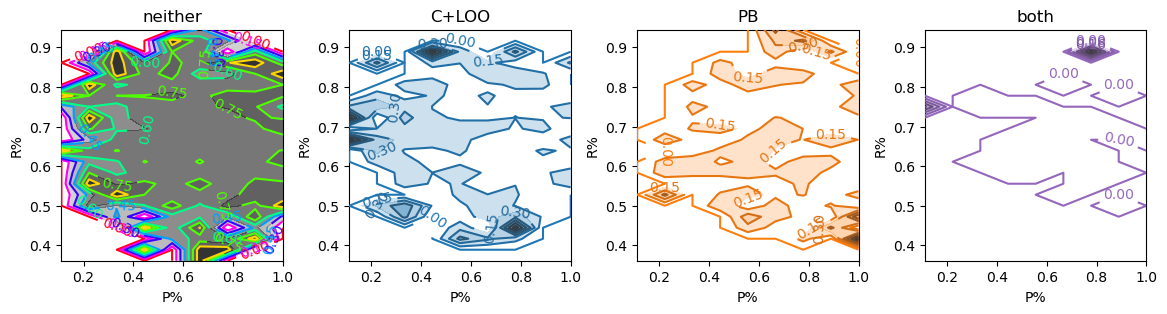

In [58]:
import matplotlib.colors as mcolors

keyx = "pathway_coverage"
keyy = "edge_coverage"

x1d = np.sort(df.loc[:, keyx].unique())
y1d = np.sort(df.loc[:, keyy].unique())
x2d, y2d = np.meshgrid(x1d, y1d)


def query_ratio(sorted_df, key):
    df_vals = sorted_df.value_counts() / sorted_df.size
    return df_vals[key] if key in df_vals.index else 0

df_ratios = pd.DataFrame({
    keyx: x2d.ravel(),
    keyy: y2d.ravel(),
    **{
        k: np.array([
            query_ratio(
                df[(df.loc[:, keyx] == x) & (df.loc[:, keyy] == y)].v,
                k
            ) for x, y in zip(x2d.ravel(), y2d.ravel())
        ]) for k in np.sort(df.v.unique())
    }
    
})

fig, ax = plt.subplots(
    1, 4, figsize=(14, 3), 
    # sharex=True, sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, a in enumerate(ax.ravel()):
    
    rgb = mcolors.to_rgb({0: ".2", 1: "C0", 2: "C1", 3: "C4"}[i])
    cmap_contour = mcolors.ListedColormap(
        [(r, g, b, 1) for r, g, b in zip(*[np.linspace(c, 0.2, 10) for c in rgb])]
    )
    
    a.contourf(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap=mcolors.ListedColormap([(*rgb, alpha) for alpha in np.linspace(1.0, 0, 10)[::-1]])
    )
    contour = a.contour(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap="hsv_r" if i == 0 else cmap_contour, 
        zorder=100
    )
    contour.clabel(fmt=f'%.{2}f')
    a.set(
        title={i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}[i],
        xlabel=feat_names_short[keyx], ylabel=feat_names_short[keyy]
    )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/contour_{key_c}_vs_{key_r}{conf.suffix}", **kwarg_savefig)

In [85]:
df.max_positive_edge_density.max()

1.0

<AxesSubplot: ylabel='max_positive_edge_density'>

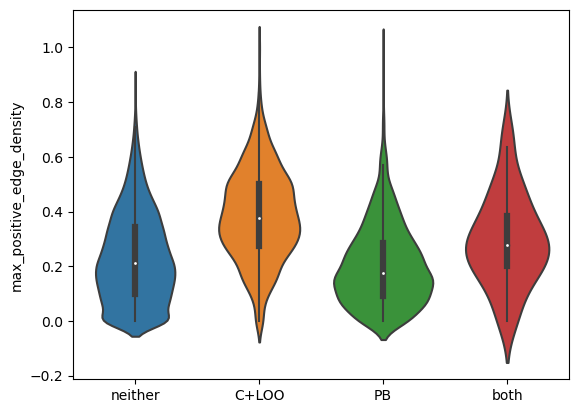

In [84]:
sns.violinplot(data=df, y=df.max_positive_edge_density, x="")

In [12]:
from doe_modules.simulation import Sim1, Circuit, Sparse

In [13]:
# model phi
cai_phi = cai(np.array([
    1, 1, 0, 0, 0, 1, 1, 0, -1,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 1, 0, 0,
    -1, 0, 0, 0, 0,
    0, -1, 0, 0,
    -1, 0, 0,
    0, 0,
    1
]))

In [14]:
# model psi
cai_psi = cai(np.array([
    1, -1, 0, 0, 0, 0, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, -1, 1, -1, 0, 0,
    1, -1, 1, 0, 0,
    1, -1, 0, 0,
    1, 0, 0,
    -1, 0,
    1
]))

In [15]:
# model lambda
cai_lambda = cai(np.array([
    1, -1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    1, -1, 1, 0, 0,
    0, -1, 0, 0,
    1, 0, 0,
    -1, 1,
    0
]))

In [16]:
argmax_recorder

{'precision': 0.20400000000000001,
 'recall': 0.725,
 'F$_1$': 0.47200000000000003}

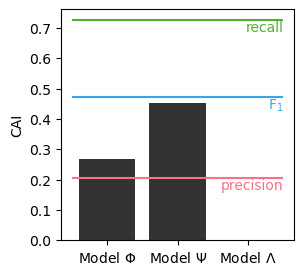

In [17]:
fig, ax= plt.subplots(figsize=(3, 3))

sns.barplot(
    data=pd.DataFrame({
        "": ["Model $\Phi$", "Model $\Psi$", "Model $\Lambda$"],
        "CAI": [cai_phi, cai_psi, cai_lambda]
    }),
    x="", y="CAI", ax=ax, color=".2"
)

xlim = ax.get_xlim()

for i, (k, v) in enumerate(argmax_recorder.items()):
    c = sns.color_palette("husl", len(argmax_recorder))
    ax.hlines(v, *xlim, color=c[i], label=k)
    ax.text(xlim[1], v, k, ha="right", va="top", color=c[i])